In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

In [68]:
# Laden des Datensatzes
data = pd.read_csv("../0_DataPreparation/Data/model_train_20130701_20180731.csv")

# Datumsformat konvertieren
data['Datum'] = pd.to_datetime(data['Datum'])

# Beispiel: Inflationsraten für jedes Jahr (beispielhafte Daten)
inflation_rates = {
    2013: 1.5,
    2014: 1.0,
    2015: 0.5,
    2016: 0.5,
    2017: 1.5,
    2018: 1.9,
    2019: 2.1,
    # Füge hier weitere Inflationsraten hinzu
}

# Nehme an, dass 'df' deinen DataFrame mit den Verkaufsdaten repräsentiert
data['year'] = data['Datum'].dt.year
data['inflation'] = data['year'].map(inflation_rates)

# Datenaufteilun7
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] > '2017-07-31') & (data['Datum'] <= '2018-08-31')]

# Features und Ziel
features = [
    'KielerWoche', 'weekend_or_holiday', 'wetter_sonnig', 'wetter_wolken', 'wetter_regen',
    'wetter_schnee', 'wetter_gewitter', 'wetter_dunst', 'wetter_nebel',
    'temp_bin_Kalt', 'temp_bin_Moderat', 'temp_bin_Warm', 'is_silvester',
    'Monat_April', 'Monat_August', 'Monat_December', 'Monat_February',
    'Monat_January', 'Monat_July', 'Monat_June', 'Monat_March', 'Monat_May',
    'Monat_November', 'Monat_October', 'Monat_September', 'inflation'
]

# Ziel (Umsatz)
target = 'Umsatz'

# Skalierung
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[features + [target]])
val_scaled = scaler.transform(val_data[features + [target]])

# Eingabe-Features und Ziel trennen
x_train = train_scaled[:, :-1]  # Alle Spalten außer Umsatz
y_train = train_scaled[:, -1]   # Letzte Spalte: Umsatz

x_val = val_scaled[:, :-1]
y_val = val_scaled[:, -1]
 

In [103]:
# Modell erstellen
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),  # Erst normalisieren
    Dropout(0.3),          # Dann Dropout
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)  
])

# Kompilierung
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluation
val_loss, val_mae = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation MAE: {val_mae}')

# Umsatzvorhersage für neue Daten
predictions = model.predict(x_val)

# Rückskalierung der Vorhersagen
predicted_umsatz = scaler.inverse_transform(
    np.hstack([x_val, predictions])  # Features + vorhergesagte Umsätze
)[:, -1]  # Nur die Umsatz-Spalte zurückholen

Epoch 1/200


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2166 - mae: 0.8600 - val_loss: 0.1244 - val_mae: 0.3352
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8772 - mae: 0.7306 - val_loss: 0.1877 - val_mae: 0.4095
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - mae: 0.6499 - val_loss: 0.1650 - val_mae: 0.3654
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5955 - mae: 0.5943 - val_loss: 0.1401 - val_mae: 0.3078
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4922 - mae: 0.5450 - val_loss: 0.1173 - val_mae: 0.2651
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4383 - mae: 0.5105 - val_loss: 0.1039 - val_mae: 0.2452
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3912 - mae: 0.4839 - val_loss: 0.0966 - val_mae: 0.2350
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3320 - mae: 0.4452 - val_loss: 0.0950 - val_mae: 0.2315
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3146 - mae: 0.4

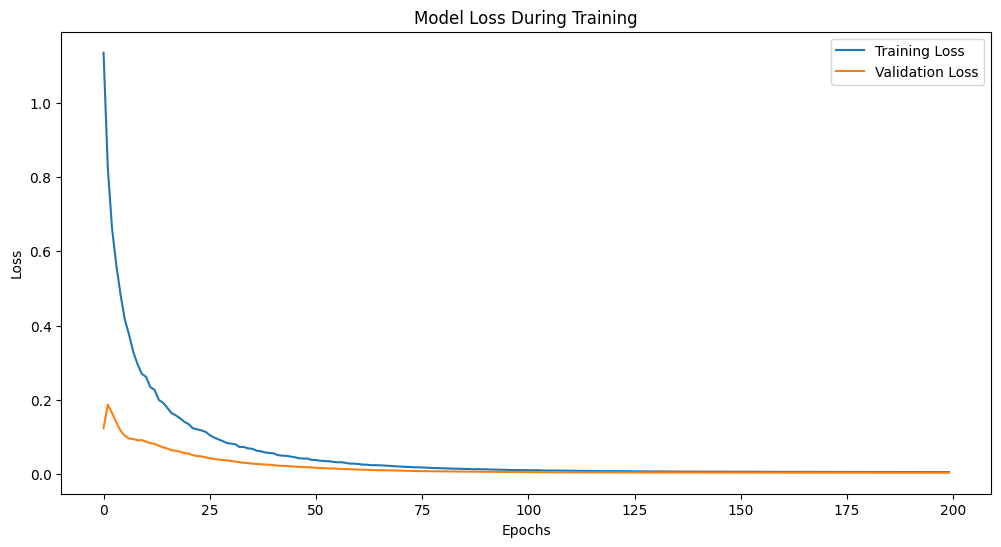

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(x_train)
validation_predictions = model.predict(x_val)
print(f"MAPE on the Training Data: {mape(y_train, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(y_val, validation_predictions):.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
MAPE on the Training Data: 102.78%
MAPE on the Validation Data: 100.07%


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


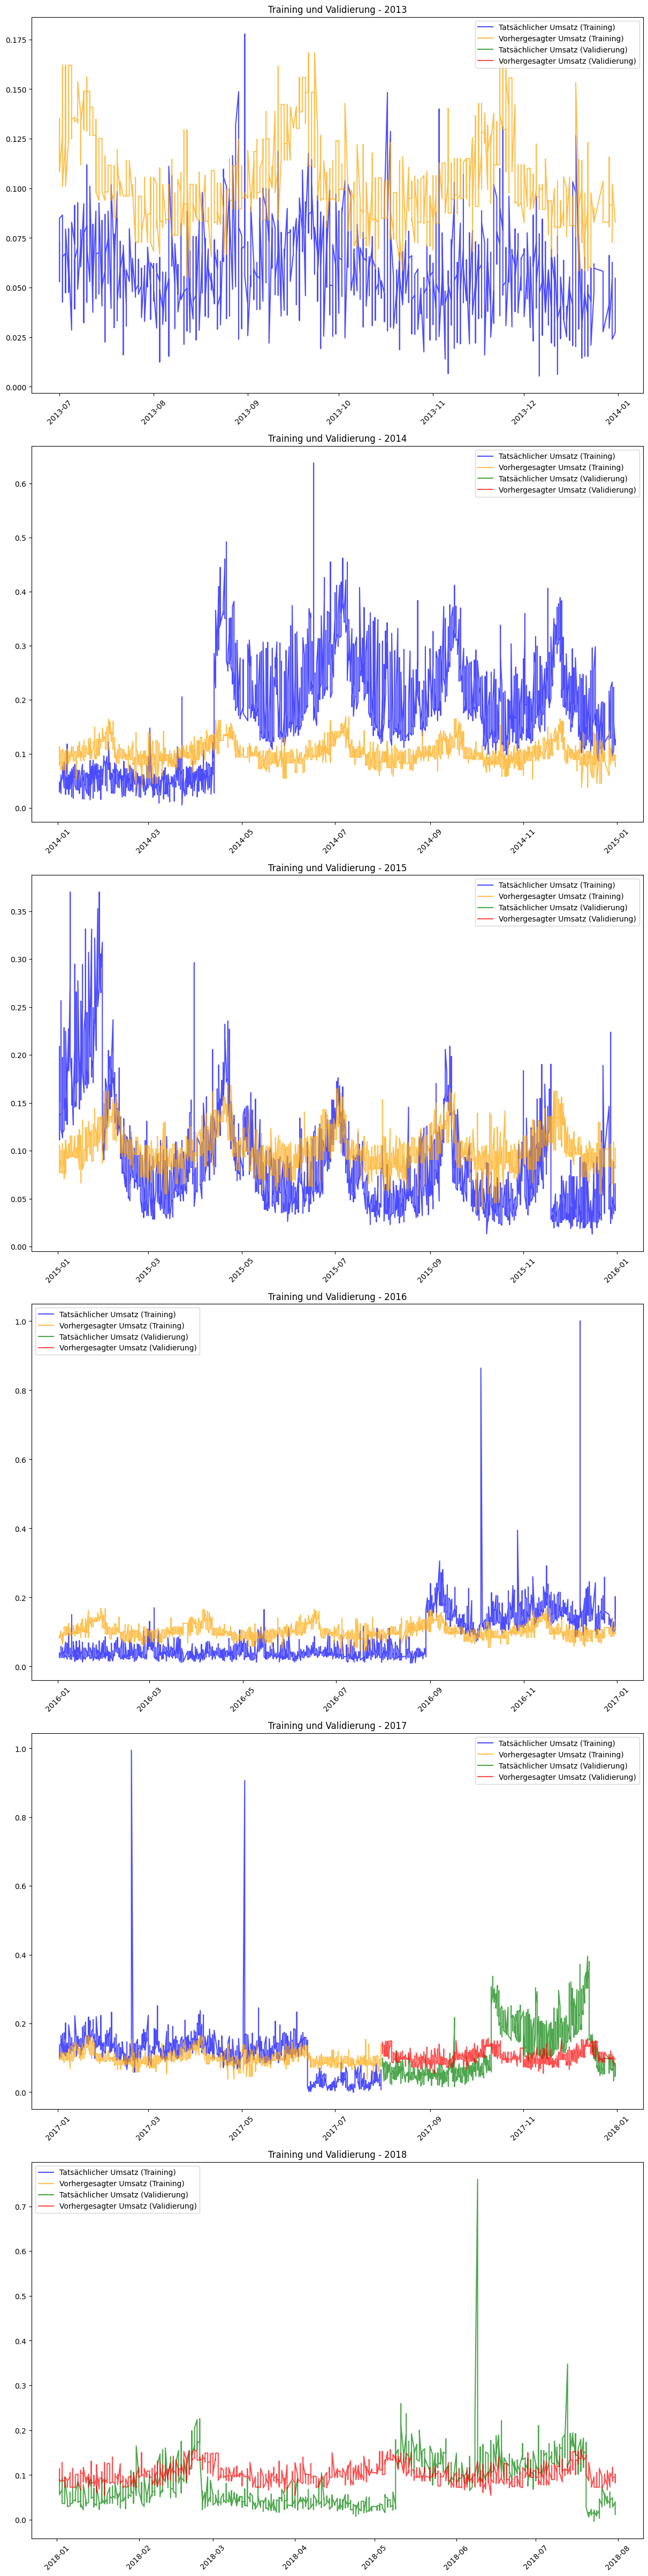

In [106]:
# Sicherstellen, dass 'Datum' als datetime formatiert ist
# Erstelle DataFrames für Trainings- und Validierungsdaten
train_data_df = pd.DataFrame(train_data, columns=["id", "Datum", "Umsatz", "KielerWoche", "weekend_or_holiday", 
                                                  "wetter_sonnig", "wetter_wolken", "wetter_regen", "wetter_schnee",
                                                  "wetter_gewitter", "wetter_dunst", "wetter_nebel", 
                                                  "temp_bin_Kalt", "temp_bin_Moderat", "temp_bin_Warm", 
                                                  "is_silvester", "Warengruppe_Broetchen", "Warengruppe_Brot", 
                                                  "Warengruppe_Croissant", "Warengruppe_Konditorei", "Warengruppe_Kuchen", 
                                                  "Warengruppe_Saisonbrot", "Monat_April", "Monat_August", "Monat_December", 
                                                  "Monat_February", "Monat_January", "Monat_July", "Monat_June", "Monat_March", 
                                                  "Monat_May", "Monat_November", "Monat_October", "Monat_September", "inflation"])

val_data_df = pd.DataFrame(val_data, columns=["id", "Datum", "Umsatz", "KielerWoche", "weekend_or_holiday", 
                                              "wetter_sonnig", "wetter_wolken", "wetter_regen", "wetter_schnee",
                                              "wetter_gewitter", "wetter_dunst", "wetter_nebel", 
                                              "temp_bin_Kalt", "temp_bin_Moderat", "temp_bin_Warm", 
                                              "is_silvester", "Warengruppe_Broetchen", "Warengruppe_Brot", 
                                              "Warengruppe_Croissant", "Warengruppe_Konditorei", "Warengruppe_Kuchen", 
                                              "Warengruppe_Saisonbrot", "Monat_April", "Monat_August", "Monat_December", 
                                              "Monat_February", "Monat_January", "Monat_July", "Monat_June", "Monat_March", 
                                              "Monat_May", "Monat_November", "Monat_October", "Monat_September", "inflation"])

# Konvertiere 'Datum' in datetime und sortiere nach Datum
train_data_df['Datum'] = pd.to_datetime(train_data_df['Datum'])
val_data_df['Datum'] = pd.to_datetime(val_data_df['Datum'])
train_data_df = train_data_df.sort_values(by='Datum')
val_data_df = val_data_df.sort_values(by='Datum')

# Erstelle DataFrames für die Vorhersagen (für Training und Validierung)
train_predictions_df = pd.DataFrame({
    'Datum': train_data_df['Datum'],
    'Tatsächlicher Umsatz': y_train.flatten(),
    'Vorhergesagter Umsatz': model.predict(x_train).flatten()  # Vorhersagen aus deinem Modell
})

val_predictions_df = pd.DataFrame({
    'Datum': val_data_df['Datum'],
    'Tatsächlicher Umsatz': y_val.flatten(),
    'Vorhergesagter Umsatz': predictions.flatten()  # Vorhersagen aus deinem Modell
})

# Funktion zur Erstellung der Subplots für jedes Jahr (mit 2 Spalten)
def plot_yearly_subplots(data_train, data_val, title, figsize=(12, 8)):
    years_train = data_train['Datum'].dt.year.unique()  # Holen Sie sich alle einzigartigen Jahre im Training
    years_val = data_val['Datum'].dt.year.unique()  # Holen Sie sich alle einzigartigen Jahre in der Validierung
    years = sorted(set(years_train) | set(years_val))  # Vereinigung der Jahre aus beiden Datensätzen

    num_years = len(years)  # Anzahl der Jahre
    ncols = 1  # 2 Spalten für die Subplots
    nrows = int(np.ceil(num_years / ncols))  # Anzahl der Zeilen basierend auf der Anzahl der Jahre
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize[0], figsize[1] * nrows), constrained_layout=True)

    # Flatten der Achsen für einfache Iteration
    axes = axes.flatten()

    for i, year in enumerate(years):
        # Filter für das Jahr in beiden Datensätzen
        yearly_train_data = data_train[data_train['Datum'].dt.year == year]
        yearly_val_data = data_val[data_val['Datum'].dt.year == year]

        ax = axes[i]
        ax.plot(yearly_train_data['Datum'], yearly_train_data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz (Training)', color='blue', alpha=0.7)
        ax.plot(yearly_train_data['Datum'], yearly_train_data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz (Training)', color='orange', alpha=0.7)

        ax.plot(yearly_val_data['Datum'], yearly_val_data['Tatsächlicher Umsatz'], label='Tatsächlicher Umsatz (Validierung)', color='green', alpha=0.7)
        ax.plot(yearly_val_data['Datum'], yearly_val_data['Vorhergesagter Umsatz'], label='Vorhergesagter Umsatz (Validierung)', color='red', alpha=0.7)

        ax.set_title(f"{title} - {year}")
        ax.tick_params(axis='x', rotation=45)  # Rotation der Datumsangaben für bessere Lesbarkeit
        ax.legend()

    # Falls weniger Jahre als Subplots vorhanden sind, verstecke ungenutzte Achsen
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

# Plots für Trainings- und Validierungsdaten
plot_yearly_subplots(train_predictions_df, val_predictions_df, "Training und Validierung")
